# DreamBooth Hackathon 🏆

Welcome to the DreamBooth Hackathon! In this competition, you'll **personalise a Stable Diffusion model by fine-tuning it on a handful of your own images.** To do so, we'll use a technique called [_DreamBooth_](https://arxiv.org/abs/2208.12242), which allows one to implant a subject (e.g. your pet or favourite dish) into the output domain of the model such that it can be synthesized with a _unique identifier_ in the prompt.

Let's dive in!

## Prerequisites

Before diving into this notebook, you should read the:

* [Unit 3 README](https://github.com/huggingface/diffusion-models-class/blob/main/unit3/README.md) that contains a deep dive into Stable Diffusion
* DreamBooth [blog post](https://dreambooth.github.io/) to get a sense of what's possible with this technique
* Hugging Face [blog post](https://huggingface.co/blog/dreambooth) on best practices for fine-tuning Stable Diffusion with DreamBooth

🚨 **Note:** the code in **this notebook requires at least 14GB of GPU vRAM** and is a simplified version of the [official training script](https://github.com/huggingface/diffusers/tree/main/examples/dreambooth) provided in 🤗 Diffusers. It produces decent models for most applications, but we recommend experimenting with the advanced features like class preservation loss & fine-tuning the text encoder if you have at least 24GB vRAM available. Check out the 🤗 Diffusers [docs](https://huggingface.co/docs/diffusers/training/dreambooth) for more details.

## What is DreamBooth?

DreamBooth is a technique to teach new concepts to Stable Diffusion using a specialized form of fine-tuning. If you're on Twitter or Reddit, you may have seen people using this technique to create (often hilarious) avatars of themselves. For example, here's what [Andrej Karpathy](https://karpathy.ai/) would look like as a cowboy (you may need to run the cell to see the output):

In [1]:
%%html
<blockquote class="twitter-tweet"><p lang="en" dir="ltr">Stableboost auto-suggests a few hundred prompts by default but you can generate additional variations for any one prompt that seems to be giving fun/interesting results, or adjust it in any way: <a href="https://t.co/qWmadiXftP">pic.twitter.com/qWmadiXftP</a></p>&mdash; Andrej Karpathy (@karpathy) <a href="https://twitter.com/karpathy/status/1600578187141840896?ref_src=twsrc%5Etfw">December 7, 2022</a></blockquote> <script async src="https://platform.twitter.com/widgets.js" charset="utf-8"></script>

The way DreamBooth works is as follows:

* Collect around 10-20 input images of a subject (e.g., your dog) and define a unique identifier [V] that refers to the subject. This identifier is usually some made up word like `flffydog` which is implanted in different text prompts at inference time to place the subject in different contexts.
* Fine-tune the diffusion model by providing the images together with a text prompt like "A photo of a [V] dog" that contains the unique identifier and class name (i.e., "dog" in this example).
* (Optionally) Apply a special _class-specific prior preservation loss_, which leverages the semantic prior that the model has on the class and encourages it to generate diverse instances belong to the subject's class by injecting the class name in the text prompt. In practice, this step is only really needed for human faces and can be skipped for the themes we'll be exploring in this hackathon.

An overview of the DreamBooth technique is shown in the image below:

![](https://dreambooth.github.io/DreamBooth_files/high_level.png)

### What can DreamBooth do?

Besides putting your subject in interesting locations, DreamBooth can be used for _**text-guided view synthesis**_, where the subject is viewed from different viewpoints as shown in the example below:

![](https://dreambooth.github.io/DreamBooth_files/novel_views.png)

DreamBooth can also be used to modify properties of the subject, such as colour or mixing up animal species!

![](https://dreambooth.github.io/DreamBooth_files/property_modification.png)

Now that we've seen some of the cool things DreamBooth can do, let's start training our own models!

## Step 1: Setup

If you're running this notebook on Google Colab or Kaggle, run the cell below to install the required libraries:

In [2]:
%pip install -qqU diffusers transformers bitsandbytes accelerate ftfy datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 20.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.8/119.8 MB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.4/302.4 kB 42.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 60.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 28.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 47.4 MB/s eta 0:00:00


If you're running on Kaggle, you'll need to install the latest PyTorch version to work with 🤗 Accelerate:

In [ ]:
# Uncomment and run if using Kaggle's notebooks. You may need to restart the notebook afterwards
# %pip install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu116

To be able to push your model to the Hub and make it appear on the [DreamBooth Leaderboard](https://huggingface.co/spaces/dreambooth-hackathon/leaderboard), there are a few more steps to follow. First you have to create an [access token](https://huggingface.co/docs/hub/security-tokens) with _**write access**_ from your Hugging Face account and then execute the following cell and input your token:

In [3]:
from huggingface_hub import notebook_login

notebook_login()

The final step is to install Git LFS:

In [ ]:
%%capture
!sudo apt -qq install git-lfs
!git config --global credential.helper store

## Step 2: Pick a theme

This competition is composed of 5 _themes_, where each theme will collect models belong to the following categories:

* **Animal 🐨:** Use this theme to generate images of your pet or favourite animal hanging out in the Acropolis, swimming, or flying in space.
* **Science 🔬:** Use this theme to generate cool synthetic images of galaxies, proteins, or any domain of the natural and medical sciences.
* **Food 🍔:** Use this theme to tune Stable Diffusion on your favourite dish or cuisine.
* **Landscape 🏔:** Use this theme to generate beautiful landscapes of your faourite mountain, lake, or garden.
* **Wildcard 🔥:** Use this theme to go wild and create Stable Diffusion models for any category of your choosing!

We'll be **giving out prizes to the top 3 most liked models per theme**, and you're encouraged to submit as many models as you want! Run the cell below to create a dropdown widget where you can select the theme you wish to submit to:

In [4]:
import ipywidgets as widgets

theme = "animal"
drop_down = widgets.Dropdown(
    options=["animal", "science", "food", "landscape", "wildcard"],
    description="Pick a theme",
    disabled=False,
)


def dropdown_handler(change):
    global theme
    theme = change.new


drop_down.observe(dropdown_handler, names="value")
display(drop_down)

Dropdown(description='Pick a theme', options=('animal', 'science', 'food', 'landscape', 'wildcard'), value='an…

In [5]:
print(f"You've selected the {theme} theme!")

You've selected the animal theme!


## Step 3: Create an image dataset and upload it to the Hub

Once you've picked a theme, the next step is to **create a dataset of images for that theme** and upload it to the Hugging Face Hub:

* You'll need around **10-20 images of the subject** that you wish to implant in the model. These can be photos you've taken or downloaded from platforms like [Unsplash](https://unsplash.com/). Alternatively, you can take a look at any of the [image datasets](https://huggingface.co/datasets?task_categories=task_categories:image-classification&sort=downloads) on the Hugging Face Hub for inspiration.
* For best results, we recommend using images of your subject from **different angles and perspectives**.

Once you've collected your images in a folder, you can upload them to the Hub by using the UI to drag and drop your images. See [this guide](https://huggingface.co/docs/datasets/upload_dataset#upload-with-the-hub-ui) for more details, or watch the video below:

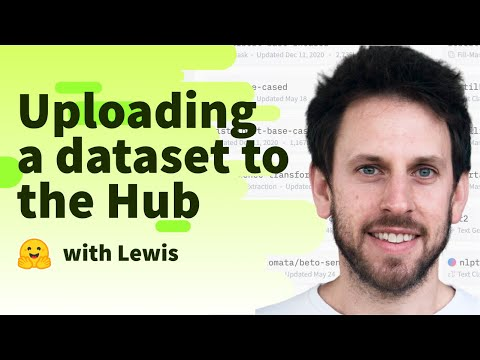

In [ ]:
from IPython.display import YouTubeVideo

YouTubeVideo("HaN6qCr_Afc")

Alternatively, you can load your dataset locally using the `imagefolder` feature of 🤗 Datasets and then push it to the Hub:

```python
from datasets import load_dataset

dataset = load_dataset("imagefolder", data_dir="your_folder_of_images")
# Push to Hub
dataset.push_to_hub("dreambooth-hackathon-images")
dataset = dataset['train']
```

Once you've created your dataset, you can download it by using the `load_dataset()` function as follows:

In [7]:
from datasets import load_dataset

dataset_id = "khanhgn/hachi_diffusion"  # CHANGE THIS TO YOUR {hub_username}/{dataset_id}
dataset = load_dataset(dataset_id, split="train")
dataset

Generating train split: 0 examples [00:00, ? examples/s]

Dataset({
    features: ['image'],
    num_rows: 4
})

Now that we have our dataset, let's define a helper function to view a few of the images:

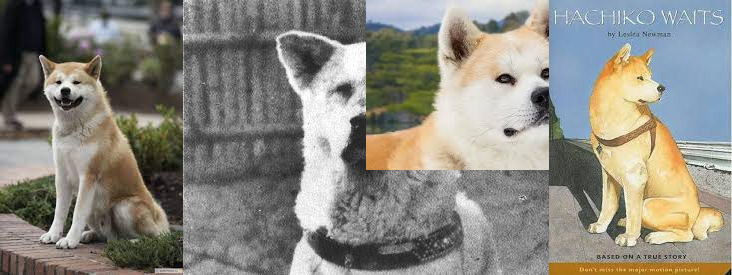

In [8]:
from PIL import Image


def image_grid(imgs, rows, cols):
    assert len(imgs) == rows * cols
    w, h = imgs[0].size
    grid = Image.new("RGB", size=(cols * w, rows * h))
    grid_w, grid_h = grid.size
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i % cols * w, i // cols * h))
    return grid


num_samples = 4
image_grid(dataset["image"][:num_samples], rows=1, cols=num_samples)

If this looks good, you can move onto the next step - creating a PyTorch dataset for training with DreamBooth.

## Step 3: Create a training dataset

To create a training set for our images we need a few components:

* An _instance prompt_ that is used to prime the model at the start of training. In most cases, using "a photo of [identifier] [class noun]" works quite well, e.g., "a photo of ccorgi dog" for our cute Corgi pictures.
    * **Note:** it is recommended that you pick a unique / made up word like `ccorgi` to describe your subject. This will ensure a common word in the model's vocabulary isn't overwritten.
* A _tokenizer_ to convert the instance prompt into input IDs that can be fed to the text encoder of Stable Diffusion.
* A set of _image transforms_, notably resizing the images to a common shape and normalizing the pixel values to a common mean and standard distribution.

With this in mind, let's start by defining the instance prompt:

In [9]:
name_of_your_concept = "ccorgi"  # CHANGE THIS ACCORDING TO YOUR SUBJECT
type_of_thing = "dog"  # CHANGE THIS ACCORDING TO YOUR SUBJECT
instance_prompt = f"a photo of {name_of_your_concept} {type_of_thing}"
print(f"Instance prompt: {instance_prompt}")

Instance prompt: a photo of ccorgi dog


Next, we need to create a PyTorch `Dataset` object that implements the `__len__` and `__getitem__` dunder methods:

In [10]:
from torch.utils.data import Dataset
from torchvision import transforms


class DreamBoothDataset(Dataset):
    def __init__(self, dataset, instance_prompt, tokenizer, size=512):
        self.dataset = dataset
        self.instance_prompt = instance_prompt
        self.tokenizer = tokenizer
        self.size = size
        self.transforms = transforms.Compose(
            [
                transforms.Resize(size),
                transforms.CenterCrop(size),
                transforms.ToTensor(),
                transforms.Normalize([0.5], [0.5]),
            ]
        )

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        example = {}
        image = self.dataset[index]["image"]
        example["instance_images"] = self.transforms(image)
        example["instance_prompt_ids"] = self.tokenizer(
            self.instance_prompt,
            padding="do_not_pad",
            truncation=True,
            max_length=self.tokenizer.model_max_length,
        ).input_ids
        return example

Great, let's now check this works by loading the CLIP tokenizer associated with the text encoder of the original Stable Diffusion model, and then creating the training dataset:

In [11]:
from transformers import CLIPTokenizer

# The Stable Diffusion checkpoint we'll fine-tune
model_id = "CompVis/stable-diffusion-v1-4"
tokenizer = CLIPTokenizer.from_pretrained(
    model_id,
    subfolder="tokenizer",
)

train_dataset = DreamBoothDataset(dataset, instance_prompt, tokenizer)
train_dataset[0]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

{'instance_images': tensor([[[-0.8510, -0.8510, -0.8510,  ..., -0.4118, -0.4118, -0.4118],
          [-0.8510, -0.8510, -0.8510,  ..., -0.4118, -0.4118, -0.4118],
          [-0.8510, -0.8510, -0.8510,  ..., -0.4118, -0.4118, -0.4118],
          ...,
          [ 0.0588,  0.0588,  0.0745,  ..., -0.0431, -0.0431, -0.0431],
          [ 0.0588,  0.0588,  0.0745,  ..., -0.0588, -0.0667, -0.0667],
          [ 0.0745,  0.0745,  0.0824,  ..., -0.0667, -0.0745, -0.0745]],
 
         [[-0.8431, -0.8431, -0.8431,  ..., -0.3961, -0.3961, -0.3961],
          [-0.8431, -0.8431, -0.8431,  ..., -0.3961, -0.3961, -0.3961],
          [-0.8431, -0.8431, -0.8431,  ..., -0.3961, -0.3961, -0.3961],
          ...,
          [-0.0353, -0.0353, -0.0196,  ..., -0.0431, -0.0510, -0.0510],
          [-0.0353, -0.0353, -0.0196,  ..., -0.0510, -0.0667, -0.0667],
          [-0.0196, -0.0196, -0.0118,  ..., -0.0588, -0.0667, -0.0667]],
 
         [[-0.8118, -0.8118, -0.8118,  ..., -0.5059, -0.5059, -0.5059],
         

## Step 4: Define a data collator

Now that we have a training dataset, the next thing we need is to define a _data collator_. A data collator is a function that collects elements in a batch of data and applies some logic to form a single tensor we can provide to the model. If you'd to learn more, you can check out this video from the [Hugging Face Course](hf.co/course):

In [12]:
YouTubeVideo("-RPeakdlHYo")

NameError: name 'YouTubeVideo' is not defined

For DreamBooth, our data collator need to provide the model with the input IDs from the tokenizer and the pixel values from the images as a stacked tensor. The function below does the trick:

In [13]:
import torch


def collate_fn(examples):
    input_ids = [example["instance_prompt_ids"] for example in examples]
    pixel_values = [example["instance_images"] for example in examples]
    pixel_values = torch.stack(pixel_values)
    pixel_values = pixel_values.to(memory_format=torch.contiguous_format).float()

    input_ids = tokenizer.pad(
        {"input_ids": input_ids}, padding=True, return_tensors="pt"
    ).input_ids

    batch = {
        "input_ids": input_ids,
        "pixel_values": pixel_values,
    }
    return batch

## Step 5: Load the components of the Stable Diffusion pipeline

We nearly have all the pieces ready for training! As you saw in the Unit 3 notebook on Stable Diffusion, the pipeline is composed of several models:

* A text encoder that converts the prompts into text embeddings. Here we're using CLIP since it's the encoder used to train Stable Diffusion v1-4.
* A VAE or variational autoencoder that converts the images to compressed representations (i.e., latents) and decompresses them at inference time.
* A UNet that applies the denoising operation on the latent of the VAE.

We can load all these components using the 🤗 Diffusers and 🤗 Transformers libraries as follows:

In [14]:
from diffusers import AutoencoderKL, UNet2DConditionModel
from transformers import CLIPFeatureExtractor, CLIPTextModel

text_encoder = CLIPTextModel.from_pretrained(model_id, subfolder="text_encoder")
vae = AutoencoderKL.from_pretrained(model_id, subfolder="vae")
unet = UNet2DConditionModel.from_pretrained(model_id, subfolder="unet")
feature_extractor = CLIPFeatureExtractor.from_pretrained("openai/clip-vit-base-patch32")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


text_encoder/config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


## Step 6: Fine-tune the model

Now comes the fun part - training our model with DreamBooth! As shown in the [Hugging Face's blog post](https://huggingface.co/blog/dreambooth), the most essential hyperparameters to tweak are the learning rate and number of training steps.

In general, you'll get better results with a lower learning rate at the expense of needing to increase the number of training steps. The values below are a good starting point, but you may need to adjust them according to your dataset:

In [16]:
learning_rate = 2e-06
max_train_steps = 400

Next, let's wrap the other hyperparameters we need in a `Namespace` object to make it easier to configure the training run:

In [17]:
from argparse import Namespace

args = Namespace(
    pretrained_model_name_or_path=model_id,
    resolution=512, # Reduce this if you want to save some memory
    train_dataset=train_dataset,
    instance_prompt=instance_prompt,
    learning_rate=learning_rate,
    max_train_steps=max_train_steps,
    train_batch_size=1,
    gradient_accumulation_steps=1, # Increase this if you want to lower memory usage
    max_grad_norm=1.0,
    gradient_checkpointing=True,  # Set this to True to lower the memory usage
    use_8bit_adam=True,  # Use 8bit optimizer from bitsandbytes
    seed=3434554,
    sample_batch_size=2,
    output_dir="my-dreambooth",  # Where to save the pipeline
)

The final step is to define a `training_function()` function that wraps the training logic and can be passed to 🤗 Accelerate to handle training on 1 or more GPUs. If this is the first time you're using 🤗 Accelerate, check out this video to get a quick overview of what it can do:

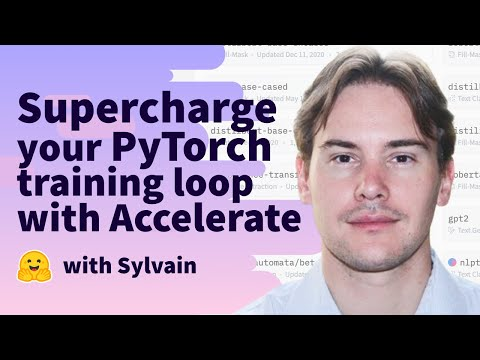

In [ ]:
YouTubeVideo("s7dy8QRgjJ0")

The details should look familiar to what we saw in Units 1 & 2 when we trained our own diffusion models from scratch:

In [18]:
import math

import torch.nn.functional as F
from accelerate import Accelerator
from accelerate.utils import set_seed
from diffusers import DDPMScheduler, PNDMScheduler, StableDiffusionPipeline
from diffusers.pipelines.stable_diffusion import StableDiffusionSafetyChecker
from torch.utils.data import DataLoader
from tqdm.auto import tqdm


def training_function(text_encoder, vae, unet):

    accelerator = Accelerator(
        gradient_accumulation_steps=args.gradient_accumulation_steps,
    )

    set_seed(args.seed)

    if args.gradient_checkpointing:
        unet.enable_gradient_checkpointing()

    # Use 8-bit Adam for lower memory usage or to fine-tune the model in 16GB GPUs
    if args.use_8bit_adam:
        import bitsandbytes as bnb
        optimizer_class = bnb.optim.AdamW8bit
    else:
        optimizer_class = torch.optim.AdamW

    optimizer = optimizer_class(
        unet.parameters(),  # Only optimize unet
        lr=args.learning_rate,
    )

    noise_scheduler = DDPMScheduler(
        beta_start=0.00085,
        beta_end=0.012,
        beta_schedule="scaled_linear",
        num_train_timesteps=1000,
    )

    train_dataloader = DataLoader(
        args.train_dataset,
        batch_size=args.train_batch_size,
        shuffle=True,
        collate_fn=collate_fn,
    )

    unet, optimizer, train_dataloader = accelerator.prepare(
        unet, optimizer, train_dataloader
    )

    # Move text_encode and vae to gpu
    text_encoder.to(accelerator.device)
    vae.to(accelerator.device)

    # We need to recalculate our total training steps as the size of the training dataloader may have changed
    num_update_steps_per_epoch = math.ceil(
        len(train_dataloader) / args.gradient_accumulation_steps
    )
    num_train_epochs = math.ceil(args.max_train_steps / num_update_steps_per_epoch)

    # Train!
    total_batch_size = (
        args.train_batch_size
        * accelerator.num_processes
        * args.gradient_accumulation_steps
    )
    # Only show the progress bar once on each machine
    progress_bar = tqdm(
        range(args.max_train_steps), disable=not accelerator.is_local_main_process
    )
    progress_bar.set_description("Steps")
    global_step = 0

    for epoch in range(num_train_epochs):
        unet.train()
        for step, batch in enumerate(train_dataloader):
            with accelerator.accumulate(unet):
                # Convert images to latent space
                with torch.no_grad():
                    latents = vae.encode(batch["pixel_values"]).latent_dist.sample()
                    latents = latents * 0.18215

                # Sample noise that we'll add to the latents
                noise = torch.randn(latents.shape).to(latents.device)
                bsz = latents.shape[0]
                # Sample a random timestep for each image
                timesteps = torch.randint(
                    0,
                    noise_scheduler.config.num_train_timesteps,
                    (bsz,),
                    device=latents.device,
                ).long()

                # Add noise to the latents according to the noise magnitude at each timestep
                # (this is the forward diffusion process)
                noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

                # Get the text embedding for conditioning
                with torch.no_grad():
                    encoder_hidden_states = text_encoder(batch["input_ids"])[0]

                # Predict the noise residual
                noise_pred = unet(
                    noisy_latents, timesteps, encoder_hidden_states
                ).sample
                loss = (
                    F.mse_loss(noise_pred, noise, reduction="none")
                    .mean([1, 2, 3])
                    .mean()
                )

                accelerator.backward(loss)
                if accelerator.sync_gradients:
                    accelerator.clip_grad_norm_(unet.parameters(), args.max_grad_norm)
                optimizer.step()
                optimizer.zero_grad()

            # Checks if the accelerator has performed an optimization step behind the scenes
            if accelerator.sync_gradients:
                progress_bar.update(1)
                global_step += 1

            logs = {"loss": loss.detach().item()}
            progress_bar.set_postfix(**logs)

            if global_step >= args.max_train_steps:
                break

        accelerator.wait_for_everyone()

    # Create the pipeline using the trained modules and save it
    if accelerator.is_main_process:
        print(f"Loading pipeline and saving to {args.output_dir}...")
        scheduler = PNDMScheduler(
            beta_start=0.00085,
            beta_end=0.012,
            beta_schedule="scaled_linear",
            skip_prk_steps=True,
            steps_offset=1,
        )
        pipeline = StableDiffusionPipeline(
            text_encoder=text_encoder,
            vae=vae,
            unet=accelerator.unwrap_model(unet),
            tokenizer=tokenizer,
            scheduler=scheduler,
            safety_checker=StableDiffusionSafetyChecker.from_pretrained(
                "CompVis/stable-diffusion-safety-checker"
            ),
            feature_extractor=feature_extractor,
        )
        pipeline.save_pretrained(args.output_dir)

Now that we have the function defined, let's train it! Depending on the size of your dataset and type of GPU, this can take anywhere from 5 minutes to 1 hour to run:

In [19]:
from accelerate import notebook_launcher

num_of_gpus = 1  # CHANGE THIS TO MATCH THE NUMBER OF GPUS YOU HAVE
notebook_launcher(
    training_function, args=(text_encoder, vae, unet), num_processes=num_of_gpus
)

Launching training on one GPU.


  0%|          | 0/400 [00:00<?, ?it/s]

Loading pipeline and saving to my-dreambooth...


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/4.55k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

In [20]:
with torch.no_grad():
    torch.cuda.empty_cache()

If you're running on a single GPU, you can free up some memory for the next section by copying the code below into a new cell and running it. For multi-GPU machines, 🤗 Accelerate doesn't allow _any_ cell to directly access the GPU with `torch.cuda`, so we don't recommend using this trick in those cases:

```python
with torch.no_grad():
    torch.cuda.empty_cache()
```

## Step 7: Run inference and inspect generations

Now that we've trained the model, let's generate some images with it to see how it fares! First we'll load the pipeline from the output directory we save the model to:

In [21]:
pipe = StableDiffusionPipeline.from_pretrained(
    args.output_dir,
    torch_dtype=torch.float16,
).to("cuda")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


Next, let's generate a few images. The `prompt` variable will later be used to set the default on the Hugging Face Hub widget, so experiment a bit to find a good one. You might also want to try creating elaborate prompts with [CLIP Interrogator](https://huggingface.co/spaces/pharma/CLIP-Interrogator):

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

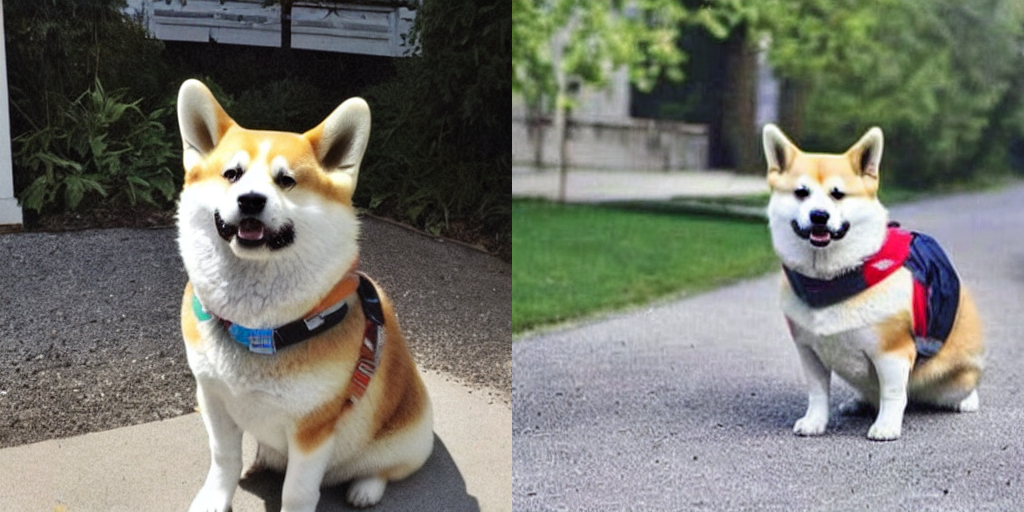

In [23]:
# Pick a funny prompt here and it will be used as the widget's default
# when we push to the Hub in the next section
prompt = f"a photo of {name_of_your_concept} {type_of_thing} in the hood"

# Tune the guidance to control how closely the generations follow the prompt
# Values between 7-11 usually work best
guidance_scale = 7

num_cols = 2
all_images = []
for _ in range(num_cols):
    images = pipe(prompt, guidance_scale=guidance_scale).images
    all_images.extend(images)

image_grid(all_images, 1, num_cols)

## Step 8: Push your model to the Hub

If you're happy with you model, the final step is to push it to the Hub and view it on the [DreamBooth Leaderboard](https://huggingface.co/spaces/dreambooth-hackathon/leaderboard)!

First, you'll need to define a name for your model repo. By default, we use the unique identifier and class name, but feel free to change this if you want:

In [ ]:
# Create a name for your model on the Hub. No spaces allowed.
model_name = f"{name_of_your_concept}-{type_of_thing}"

Next, add a brief description on the type of model you've trained or any other information you'd like to share:

In [ ]:
# Describe the theme and model you've trained
description = f"""
This is a Stable Diffusion model fine-tuned on `{type_of_thing}` images for the {theme} theme.
"""

Finally, run the cell below to create a repo on the Hub and push all our files with a nice model card to boot:

In [ ]:
# Code to upload a pipeline saved locally to the hub
from huggingface_hub import HfApi, ModelCard, create_repo, get_full_repo_name

# Set up repo and upload files
hub_model_id = get_full_repo_name(model_name)
create_repo(hub_model_id)
api = HfApi()
api.upload_folder(folder_path=args.output_dir, path_in_repo="", repo_id=hub_model_id)

content = f"""
---
license: creativeml-openrail-m
tags:
- pytorch
- diffusers
- stable-diffusion
- text-to-image
- diffusion-models-class
- dreambooth-hackathon
- {theme}
widget:
- text: {prompt}
---

# DreamBooth model for the {name_of_your_concept} concept trained by {api.whoami()["name"]} on the {dataset_id} dataset.

This is a Stable Diffusion model fine-tuned on the {name_of_your_concept} concept with DreamBooth. It can be used by modifying the `instance_prompt`: **{instance_prompt}**

This model was created as part of the DreamBooth Hackathon 🔥. Visit the [organisation page](https://huggingface.co/dreambooth-hackathon) for instructions on how to take part!

## Description

{description}

## Usage

```python
from diffusers import StableDiffusionPipeline

pipeline = StableDiffusionPipeline.from_pretrained('{hub_model_id}')
image = pipeline().images[0]
image
```
"""

card = ModelCard(content)
hub_url = card.push_to_hub(hub_model_id)
print(f"Upload successful! Model can be found here: {hub_url}")
print(
    f"View your submission on the public leaderboard here: https://huggingface.co/spaces/dreambooth-hackathon/leaderboard"
)

Upload successful! Model can be found here: https://huggingface.co/lewtun/test-dogs/blob/main/README.md
View your submission on the public leaderboard here: https://huggingface.co/spaces/dreambooth-hackathon/leaderboard


## Step 9: Celebrate 🥳

Congratulations, you've trained your very first DreamBooth model! You can train as many models as you want for the competition - the important thing is that **the most liked models will win prizes** so don't forget to share your creation far and wide to get the most votes!